# Package loading

In [38]:
import numpy as np
import pandas as pd
import os
import shapely
from shapely.geometry.point import Point
import dxfgrabber as dxfgb
import matplotlib.pyplot as plt

# Package documentation

http://dxfgrabber.readthedocs.io/en/latest/  
https://shapely.readthedocs.io/en/latest/

# DXF laoding

In [667]:
#List of all the dixs in the folder
dxffolder = os.path.join('/', *os.getcwd().split('/')[:-1], 'Sample', 'DXF')
dxflist = [os.path.join(dxffolder, file) for file in os.listdir(dxffolder) if file.endswith('.dxf')]
#dxflist

In [3]:
dxf = dxfgb.readfile(dxflist[0])
print("DXF version: {}".format(dxf.dxfversion))


DXF version: AC1015


In [4]:
header_var_count = len(dxf.header) # dict of dxf header vars
header_var_count

36

In [5]:
layer_count = len(dxf.layers) # collection of layer definitions
layer_count

14

In [6]:
block_definition_count = len(dxf.blocks) #  dict like collection of block definitions
block_definition_count

2

In [7]:
entity_count = len(dxf.entities) # list like collection of entities
entity_count

51

In [104]:
for x in [element for element in dxf.modelspace() if element.dxftype == 'LINE']:
    print(np.round(x.start,3))
    #print(x.end)
    #print(x.color)

[ -70.84   260.271]
[ -70.84  215.66]
[ -70.84   112.454]
[-70.84   30.625]
[-70.84  89.44]
[ -70.84   112.454]
[ -70.84  215.66]
[ 435.336   29.625]
[ 388.16    54.022]
[ 170.66    54.022]
[-46.84   54.022]
[-50.84   65.022]
[ 166.66    65.022]
[ 384.16    65.022]
[ 425.203  112.649]
[ 369.84   216.358]
[ 424.13   114.832]
[ 429.696  111.323]
[ 373.487  219.07 ]
[ -62.382  270.215]
[ 394.716  263.559]
[ 474.298  112.308]
[ 371.5    219.308]
[ 426.622  111.545]
[ 429.112  106.3  ]
[ 357.121  269.493]
[ 436.336   89.44 ]
[ 436.336   89.44 ]
[ 396.505  263.591]


# DXF reading module

In [662]:
def arccoord(center, radius, angle):
    xc, yc = center
    xa = xc + radius * np.cos(angle / 180 * np.pi)
    ya = yc + radius * np.sin(angle / 180 * np.pi)
    return np.array((xa, ya))

class DxfParser():
    def __init__(self, edge_color=3,
                 bend_color=0,
                 text_color=1,
                 etching_color=2,
                 min_edge_length=.05,
                 roundigexp=5):
        """Class parameters definition"""
        
        self.bend_color = bend_color
        self.text_color = text_color
        self.min_edge_length = min_edge_length
        self.etching_color = etching_color
        self.edge_color = edge_color
        self.roundigexp = roundigexp
        self.details = {}
    
    def load_dxf(self, dxfpath):
        """Loads the DXF file"""
        self.dxf = dxfgb.readfile(dxfpath)
    
    def bend_details(self):
        """Populates information such as nuber of bends, direction"""
        pass
    
    def pattern_details(self, color):
        """Constructs the pattern with shapely"""
        patterns = []
        closedpatterns = []
        openpatterns = [] #Used to track all the segment in the DXF
        for element in [element for element in self.dxf.modelspace() if element.color == color]:
            #print(element)
            #start = None
            #end = None
            #coordsectlist = None
            newitemclosed = False
            
            if element.dxftype == 'LINE':
                start = np.round(element.start, decimals=self.roundigexp)
                end = np.round(element.end, decimals=self.roundigexp)
                coordsectlist = np.round(np.array((start, end)), decimals=self.roundigexp)
            elif element.dxftype == 'MTEXT':
                print(element.raw_text)
            elif element.dxftype == 'ARC':
                start = np.round(arccoord(element.center, element.radius, element.start_angle), self.roundigexp)
                end = np.round(arccoord(element.center, element.radius, element.end_angle), self.roundigexp)
                coordsectlist = np.round(np.array((start, end)), decimals=self.roundigexp)
                #anglesteps = (element.end_angle - element.start_angle) / (2*np.arcsin(self.min_edge_length))
            elif element.dxftype == 'ELLIPSE':
                print(element.center, element.major_axis, element.ratio, element.start_param, element.end_param)
            elif element.dxftype == 'CIRCLE':
                center = Point([round(x, self.roundigexp) for x in element.center])
                circle = center.buffer(element.radius)
                coordsectlist = np.round(circle.exterior.coords, self.roundigexp)
                closedpatterns.append(coordsectlist)
            elif element.dxftype == 'SPLINE':
                #start = tuple(np.array([round(x, self.roundigexp) for x in element.control_points[0]]).tolist())
                #end = tuple(np.array([round(x, self.roundigexp) for x in element.control_points[-1]]).tolist())
                coordsectlist = np.round(element.control_points, self.roundigexp)
            
            patterns.append(coordsectlist)
        
        
        #Construcion of the different patterns
        currentsegment = np.array(patterns[0])
        del patterns[0]
        while len(patterns) != 0:
            modifiedloop = False
            for index, segment in enumerate(patterns):
                start = tuple(np.array(segment[0]).tolist())
                end = tuple(np.array(segment[-1]).tolist())
                endsegment = tuple(np.round(currentsegment[-1], self.roundigexp).tolist())
                #print(endsegment)
                #print(start)
                
                if endsegment == start:
                    currentsegment = np.concatenate((currentsegment, segment[::]))
                    del patterns[index]
                    modifiedloop = True
                    break
                elif endsegment == end:
                    currentsegment = np.concatenate((currentsegment, segment[::-1]))
                    del patterns[index]
                    modifiedloop = True
                    break

                if tuple(currentsegment[0]) == tuple(currentsegment[-1]): #The loop is closed
                    #print('Je ferme la boucle')
                    closedpatterns.append(currentsegment)
                    currentsegment = np.array(patterns[0])
                    del patterns[0]
                    modifiedloop = True
                    break
                    
            if not modifiedloop:
                openpatterns.append(currentsegment)
                currentsegment = np.array(patterns[0])
                del patterns[0]

        return (closedpatterns, openpatterns)
            
    
    def surface(self):
        """Misc Surface calculation"""
        areas = np.array([Polygon(poly).area for poly in self.details['closed_patterns']])
        biggestarea = np.argmax(areas)
        self.details['total_area'] = 2 * areas[biggestarea] - areas.sum()
        mainpattern = Polygon(self.details['closed_patterns'][biggestarea])
        self.details['minimum_rectangle_coords'] = mainpattern.minimum_rotated_rectangle.exterior.coords[:]
        self.details['minimum_rectangle_area'] = Polygon(self.details['minimum_rectangle_coords']).area
        
        self.details['convex_hull_coords'] = mainpattern.convex_hull.exterior.coords[:]
        self.details['convex_hull_area'] = Polygon(self.details['convex_hull_coords']).area
    #Bound, area, convex_hull and minimum_rotated_rectangle methods
    
    
    def bend_placement(self):
        """Populates all the information relative to the bend placement"""
        pass
    
    def parse(self, dxfpath):
        """Method to call to parse a DXF file, will return a dict with all the needed information"""
        self.load_dxf(dxfpath)
        #Cutting patter
        self.details['closed_patterns'], self.details['open_patterns']= self.pattern_details(self.edge_color)
        
        #Hetching pattern
        #TO DO
        
        #surface calculations
        self.surface()
        
        
        
        return self.details
    
    def set_params(self, **kwargs):
        """Used to set all the params"""
        for key, value in kwargs.items():
            setattr(self, key, value)
    
    def get_params(self):
        """Method to get all the parameters of the DXF parser"""
        return {key:value for key, value in vars(self).items()}

In [663]:
dxfparser = DxfParser()
#print(dxflist[0])
details = dxfparser.parse(dxflist[0])
details.keys()
#details['total_surface']

dict_keys(['closed_patterns', 'open_patterns', 'total_area', 'minimum_rectangle_coords', 'minimum_rectangle_area', 'convex_hull_coords', 'convex_hull_area'])

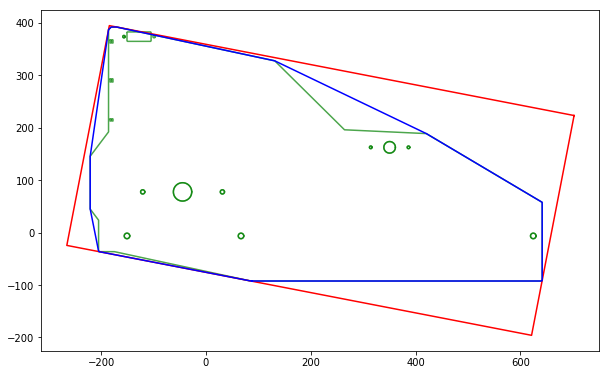

In [666]:
plot_dxf(details)

# Plot a DXF

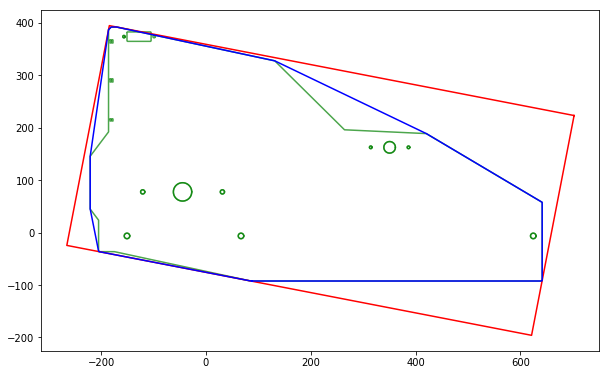

In [670]:
def plot_dxf(dxfdetails):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    for closedsection in dxfdetails['closed_patterns']:
        poly = Polygon(closedsection)
        x, y = poly.exterior.xy
        plt.plot(x, y, color='g', alpha=0.7, solid_capstyle='round')
    
    poly = Polygon(dxfdetails['minimum_rectangle_coords'])
    x, y = poly.exterior.xy
    plt.plot(x, y, color='r')
    
    poly = Polygon(dxfdetails['convex_hull_coords'])
    x, y = poly.exterior.xy
    plt.plot(x, y, color='b')
    
    ax.set_aspect('equal')
    
    plt.show()
    
plot_dxf(details)

In [118]:
import numpy as np
import shapely
from shapely.geometry.point import Point
import matplotlib.pyplot as plt
p = Point(0, 0)
circle = p.buffer(3.0)
a = np.array(circle.exterior.coords)

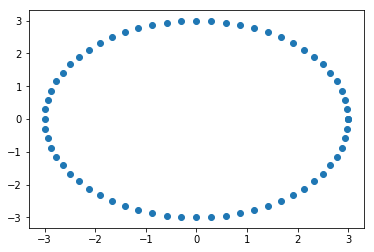

In [49]:
plt.scatter(x=np.array(circle.exterior.coords)[:,0], y=np.array(circle.exterior.coords)[:,1])
plt.show()

In [70]:
import shapely.affinity

circle=Point(0,0).buffer(1) #type(circle)=polygon
ellipse=shapely.affinity.scale(circle,15,20) #type(ellipse)=polygon

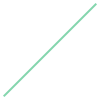

In [54]:
from shapely.geometry import LineString
#LineString(np.array(circle.exterior.coords))
LineString([(0.0, 0.0), (1.0, 1.0)])

In [62]:
from shapely.geometry.polygon import LinearRing
LinearRing([(0, 0), (1, 1), (1, 0), (0, 0),]).area

0.0

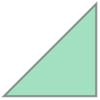

In [74]:
from shapely.geometry import Polygon
m = Polygon([(0, 0), (1, 1), (1, 0), (0, 0),(0, 0),])
m

In [94]:
np.concatenate((a,a), axis=0).shape

(132, 2)

In [99]:
dicto = {'a':1, 'b':2}
dicto.keys()

dict_keys(['a', 'b'])

In [98]:
del dicto['a']
dicto

{'b': 2}

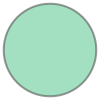

In [101]:
Polygon(a)